# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

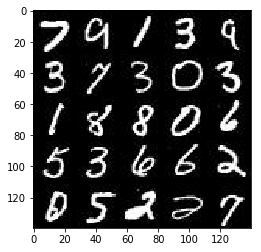

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

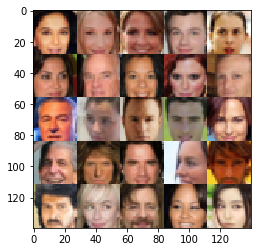

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    fake = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32)

    return real, fake, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        #Shape starts as 28*28*3
        x1 = tf.layers.conv2d(inputs=images, 
                              filters=64, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Apply leaky relu
        x1 = tf.maximum(alpha * x1, x1)
        #Shape now is: 14*14*64
        
        x2 = tf.layers.conv2d(inputs=x1, 
                              filters=128, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Use batch normalization.
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
        #Shape is now: 7*7*128
        
        x3 = tf.layers.conv2d(inputs=x2, 
                              filters=256, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * alpha)
        #Shape is now: 4*4*256
        
        #Flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.contrib.layers.fully_connected(flat, 1, activation_fn=None)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        #Reshape to start deconvolutions.
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(inputs=x1, 
                                        filters=256, 
                                        kernel_size=(4, 4), 
                                        strides=(2,2), 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #Shape is 8*8*256
        
        x3 = tf.layers.conv2d_transpose(inputs=x2,
                                        filters=128,
                                        kernel_size=(4, 4),
                                        strides=(2, 2),
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        #Shape is now 16*16*128
        
        x4 = tf.layers.conv2d_transpose(inputs=x3, 
                                            filters=out_channel_dim, 
                                            kernel_size=(5, 5), 
                                            strides=(2, 2), 
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Shape is now 32*32*3
        #Final layer to add depth.
        logits = tf.layers.conv2d_transpose(inputs=x4, 
                                            filters=out_channel_dim, 
                                            kernel_size=(5, 5), 
                                            strides=(1, 1), 
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        logits = tf.image.resize_images(logits, (28, 28))
        #Shape is now 28*28*3
        
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_logits_real = discriminator(input_real)
    d_logits_fake = discriminator(g_output, reuse=True)
    
    smooth_val = 0.1
    smooth_factor = (1 - smooth_val)
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * smooth_factor))
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    
    d_loss= d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                     tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=disc_vars)
        gen_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=gen_vars)
    
    return disc_optimizer, gen_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_fake, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_fake, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run Optimizer
                _ = sess.run(d_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                
                #Run Generator optimizer.
                _ = sess.run(g_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                _ = sess.run(g_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                
                if(steps % 10 == 0):
                    train_loss_d = d_loss.eval({input_real: batch_images, input_fake: batch_z })
                    train_loss_g = g_loss.eval({input_fake: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if(steps % 100 == 0):
                    show_generator_output(sess, 9, input_fake, data_shape[3], data_image_mode)
            
            saver.save(sess, './checkpoints/checkpoint.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.7884
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 1.1827
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 1.6085
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 1.2590
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.3730
Epoch 1/2... Discriminator Loss: 1.5706... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.9402... Generator Loss: 0.4454
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.6874
Epoch 1/2... Discriminator Loss: 2.1488... Generator Loss: 0.8206


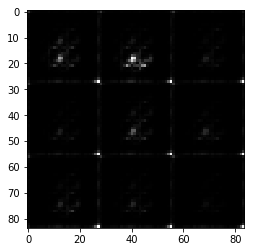

Epoch 1/2... Discriminator Loss: 2.1290... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 1.9668... Generator Loss: 0.8573
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 1.4347
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.6266... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 2.2143... Generator Loss: 1.1801
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 1.2367
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 1.1895
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 1.0368


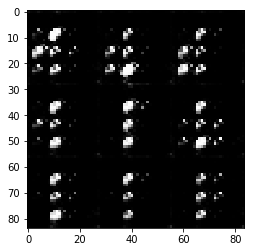

Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 1.6251
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 0.9627
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 1.2599
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 1.1845
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 1.5758
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.8180
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 1.4529
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 1.4433


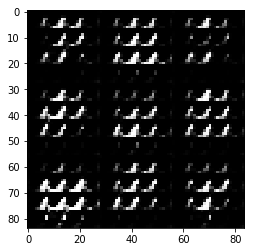

Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.7584
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 1.2954
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 1.1674
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 1.3507
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 2.1563
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.7363
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 1.5332
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.4447
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 1.7149
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 1.8442


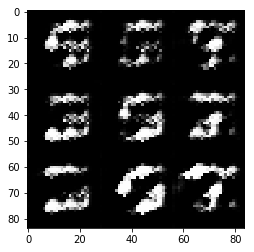

Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 2.1634
Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 2.3103
Epoch 1/2... Discriminator Loss: 0.7768... Generator Loss: 2.0969
Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 2.1871
Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 2.1863
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.8146
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 2.0308
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 2.2875
Epoch 1/2... Discriminator Loss: 0.7787... Generator Loss: 2.2729
Epoch 1/2... Discriminator Loss: 0.7777... Generator Loss: 2.0660


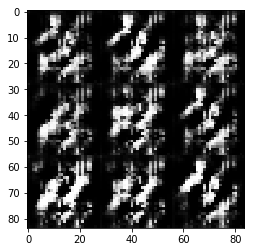

Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.9698
Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 1.5264
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.6419
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.2517
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.9082... Generator Loss: 0.5259
Epoch 1/2... Discriminator Loss: 2.7934... Generator Loss: 0.2864
Epoch 1/2... Discriminator Loss: 1.5261... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 2.2253... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 1.0286


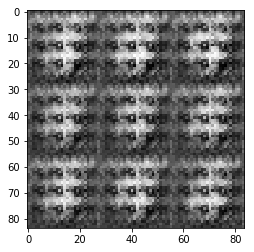

Epoch 1/2... Discriminator Loss: 1.6875... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 1.1508
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.9305... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 1.4186
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 1.2911
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.8643


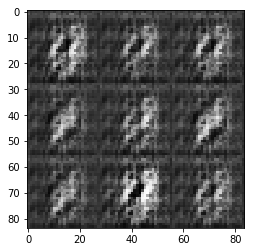

Epoch 1/2... Discriminator Loss: 1.0495... Generator Loss: 1.0572
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 1.0784
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.8289
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 1.2172
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 1.0043
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.9171


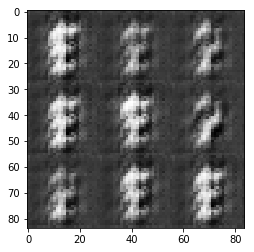

Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 1.4975
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 1.0421... Generator Loss: 1.5794
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.9083
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 1.2474
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 1.2831
Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 1.1822
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 1.2567
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 0.9819
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.3474


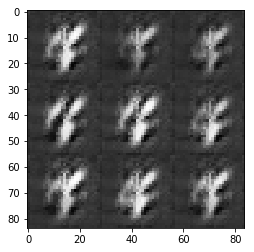

Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 1.2684
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 1.2098
Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 1.2659
Epoch 1/2... Discriminator Loss: 0.9316... Generator Loss: 1.3080
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.3103
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.7079
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.4593
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.5435
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 1.3603


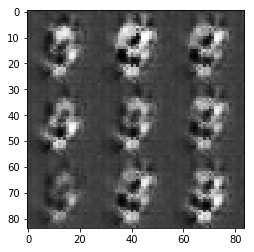

Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.5519
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 1.2108
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.4050
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.4711
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.2822
Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 1.7292
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.1509
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.5516
Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 1.4131


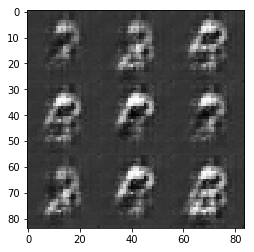

Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 1.2783
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 1.0272
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.3618
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 1.6110
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.5855
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 1.7742
Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 1.4837
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 1.5646
Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 0.9961... Generator Loss: 1.2622


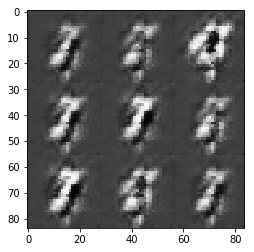

Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 1.5500
Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 1.7201
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 1.3550
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 1.3941
Epoch 1/2... Discriminator Loss: 0.9079... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 1.4289
Epoch 1/2... Discriminator Loss: 0.8320... Generator Loss: 1.7981
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.5081
Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 2.0652
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 2.1399


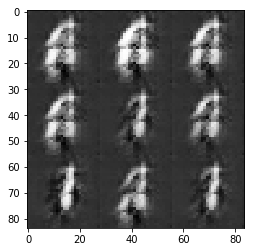

Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 1.0458
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.4876
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.6774
Epoch 1/2... Discriminator Loss: 0.8771... Generator Loss: 1.7817
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 2.1624


KeyboardInterrupt: 

In [25]:
batch_size = 32
z_dim = 50
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.